### To Do:
* Build Efficient Frontier Visualizations
* Figure out no short-sell constraint
* Get Risk Free Rate
* Build Fama-French Portfolio Evaluator

In [1]:
import pandas as pd
import datetime as dt
import requests
import json
import csv

import pandas_datareader.data as pdr
import quandl

import statsmodels.api as sm
import statsmodels.formula.api as smf

import numpy as np
from scipy.optimize import minimize


import matplotlib.pyplot as plt

%matplotlib inline

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Query Parameters

#tickers = ['SPY','SIZ','CHEP','MOM','VIX']
tickers = ['VTI','BLDP','AAPL','F','TSLA','FB','GOOGL']

start = dt.datetime(2000,1,1)
end = dt.datetime.today().date()

### Get Data

[Alpha Vantage API documentation](https://www.alphavantage.co/documentation/)

In [3]:
alphvan_key = "4X35DPOWF8QL5X42"

url = 'https://www.alphavantage.co/query'

av_data = dict()

for ticker in tickers:
    parameters = {
        'function' : 'TIME_SERIES_DAILY_ADJUSTED',
        'symbol' : ticker,
        'apikey' : alphvan_key,
        'outputsize' : 'full',
        'datatype' : 'json'
          }

    resp = requests.get(url,params=parameters).json()

    alph_van = pd.DataFrame(resp['Time Series (Daily)']).transpose()
    alph_van.index = pd.DatetimeIndex(alph_van.index)
    alph_van = alph_van.astype(float)
    av_data[ticker] = alph_van

price_key = '5. adjusted close'

[Quandl API documentation](https://docs.quandl.com/docs/data-organization)

Pandas Datareader

### Consolidate Prices

In [4]:
def merge_prices(data_dict,price_key,
                 start_date=start,end_date=end,):

    """Returns adj. close prices of queried stocks"""

    data = data_dict
    dates = pd.date_range(start=start_date, end=end_date)
    prices = pd.DataFrame(index=dates)
    for ticker in data.keys():

        price_col =  pd.DataFrame(
            data[ticker][price_key]
        ).rename({price_key:ticker},axis=1)

        prices = pd.merge(prices,price_col,
                         how='inner',
                         left_index=True,right_index=True)
    return prices

In [5]:
prices = merge_prices(av_data,price_key)

In [6]:
rsmps = ['W','Q','M','A']

In [7]:
returns_data = {'D':prices.pct_change().iloc[1:]}
for rp in rsmps:
    returns_data[rp] = prices.resample(rp).first().pct_change().iloc[1:]

In [8]:
# Set default returns series
rsample = 'W'
global_returns = returns_data[rsample]

In [9]:
annualize = {
    'A' : 1,
    'Q' : 4,
    'M' : 12,
    'W' : 12*4,
    'D' : 365
}

ann_factor = annualize[rsample]

### Data Analysis and Visualization

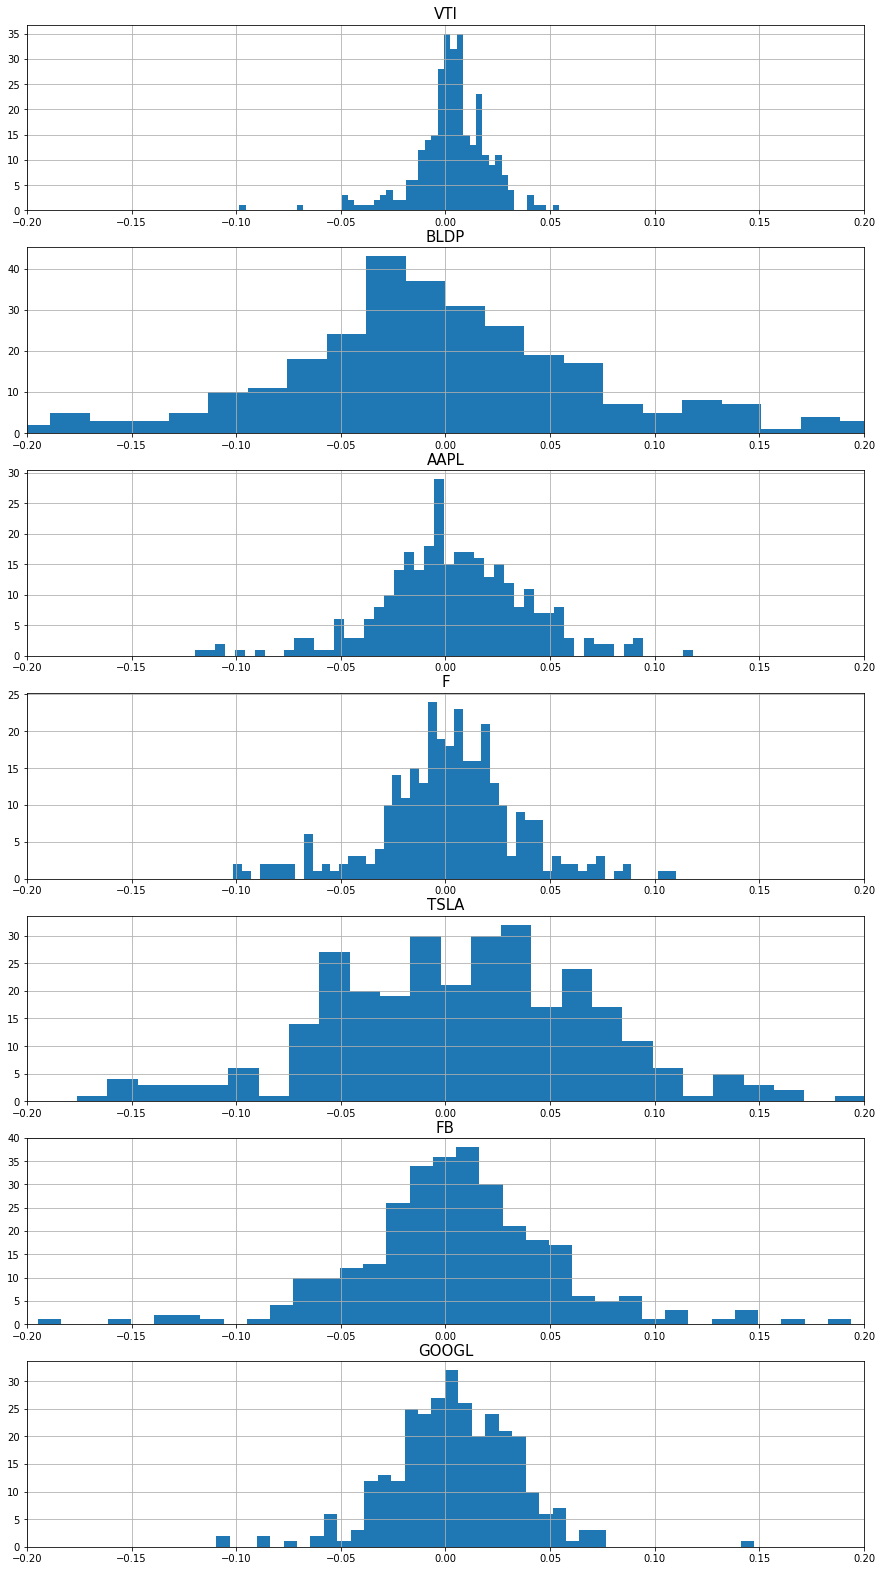

In [10]:
# Returns Histograms

fig, ax = plt.subplots(nrows = len(tickers),ncols=1,
                       figsize=(15,len(tickers)*4))

min_std = global_returns.min().std()
min_mean = global_returns.min().mean()
max_std = global_returns.max().std()
max_mean = global_returns.max().mean()

for i in range(len(tickers)):
    min_sigma = abs(global_returns[tickers[i]].min() - min_mean) / min_std
    max_sigma = abs(global_returns[tickers[i]].max() - max_mean) / max_std
    
    if max_sigma < 1.5 or min_sigma < 1.5:
        global_returns[tickers[i]].hist(bins = 50,ax=ax[i])
        ax[i].set_title(tickers[i],fontsize=15)
        ax[i].set_xlim(-.2,.2)
    else:
        global_returns[tickers[i]].hist(bins = 50,ax=ax[i])
        ax[i].set_title(tickers[i]+' (unique x-scale)',fontsize=15)

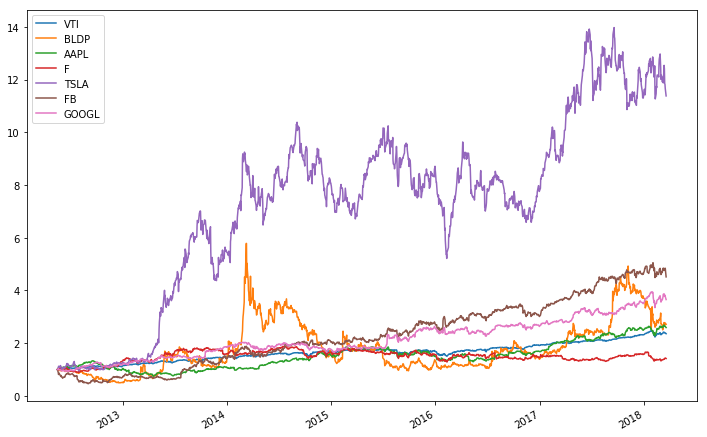

In [11]:
# normalized price growth
normalized = prices / prices.iloc[0]
normalized.plot(figsize=(12,8))

In [12]:
# Annualized Returns
global_returns.mean()*ann_factor

VTI      0.142487
BLDP     0.445607
AAPL     0.180685
F        0.081837
TSLA     0.506068
FB       0.301455
GOOGL    0.229243
dtype: float64

In [13]:
# Standard deviation (annualized)
global_returns.std()*np.sqrt(ann_factor)

VTI      0.120433
BLDP     0.816591
AAPL     0.247204
F        0.231211
TSLA     0.502247
FB       0.362441
GOOGL    0.225347
dtype: float64

In [14]:
# Correlation Matrix
global_returns.corr()

,VTI,BLDP,AAPL,F,TSLA,FB,GOOGL
VTI,1.000000,0.291590,0.437403,0.590389,0.369860,0.326419,0.588622
BLDP,0.291590,1.000000,0.121325,0.220820,0.211688,0.095351,0.148786
AAPL,0.437403,0.121325,1.000000,0.213936,0.191389,0.187496,0.338972
F,0.590389,0.220820,0.213936,1.000000,0.205807,0.180017,0.229223
TSLA,0.369860,0.211688,0.191389,0.205807,1.000000,0.284207,0.259877
FB,0.326419,0.095351,0.187496,0.180017,0.284207,1.000000,0.380970
GOOGL,0.588622,0.148786,0.338972,0.229223,0.259877,0.380970,1.000000


In [15]:
# Skewness
global_returns.skew()

VTI     -1.150912
BLDP     2.440217
AAPL    -0.248628
F       -0.234877
TSLA     0.801833
FB       0.957861
GOOGL    0.701807
dtype: float64

In [16]:
# Kurtosis
global_returns.kurt()

VTI       4.995882
BLDP     11.189133
AAPL      1.179651
F         1.275867
TSLA      5.880358
FB        7.895939
GOOGL     6.377540
dtype: float64

### Portfolio Optimization

In [17]:
def wts(weights):
    return pd.DataFrame({'weights':weights},
                        index=tickers).transpose()

In [18]:
def get_portfolio(weights,data=global_returns,
              param='sharpe_ratio',opt=False):

    port_wt = pd.DataFrame({'weights':weights},
                        index=tickers).transpose()

    cov = data.cov()

    partials = port_wt.dot(cov)*port_wt
    partials.rename({'weights':'Partials'},
                    axis = 0,inplace=True)

    port_var = partials.sum(axis=1)[0]

    port_std = np.sqrt(port_var)

    port_return = (data.mean()*port_wt).sum(axis=1)[0]

    sharpe_ratio = port_return/port_std
    
    
    param = param[:2].lower()
    
    if param not in ['sh','sr','va','re','st','we']:
        new_param = input("""Choose param options:\n
        sharpe_ratio,\n
        variance,\n
        standard_deviation,\n
        returns,or\n
        weights\n""")
        
        param = new_param[:2].lower()
    if param in ['sh', 'sr']:
        if opt==False:
            return sharpe_ratio
        elif opt==True:
            return -sharpe_ratio
        
    elif param == 'va':
        return port_var
    
    elif param == 're':
        if opt==False:
            return port_return
        elif opt==True:
            return -port_return
        
    elif param == 'st':
        return port_std
    
    elif param =='we':
        return port_wt
    else:
        print('PORTFOLIO PARAMETER ERROR')

In [19]:
def portfolio_optimize(weights,objective,data):
    return get_portfolio(weights,param=objective,opt=True,data=data)

[Scipy Optimize Reference](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)<br>
[Scipy Optimize Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)

In [20]:
def optimize(objective='sharpe_ratio',allow_short=False,data=global_returns):
    
    cons = [{'type':'eq',
            'fun':lambda x: np.array(sum(x)-1)}]
    # no short constraint where x[i] >= 0

    #initial values    
    x0 = np.array([1/len(tickers) for n in range(len(tickers))])
    if allow_short == False:
        res = minimize(portfolio_optimize, x0, args=(objective,data),
                        method='SLSQP',
                        constraints=cons,
                        bounds = [(0,None) for i in range(len(tickers))],
                        options={'disp': False})
    elif allow_short == True:
        res = minimize(portfolio_optimize, x0, args=(objective,data),
                        method='SLSQP',
                        constraints=cons,
                        bounds = [(None,None) for i in range(len(tickers))],
                        options={'disp': False})
    return res.x

In [21]:
def port_returns(data=global_returns, output_wts = False,
                 opt_obj='sharpe ratio',allow_short=False):

    port_res = get_portfolio(optimize(objective=opt_obj,
                                      data=data,
                                      allow_short=allow_short),
                             param='weights', data=data)

    port_returns = data*port_res.loc['weights']
    port_returns['portfolio'] = port_returns.sum(axis=1)
    
    if output_wts == False:
        return port_returns
    elif output_wts == True:
        return port_returns, port_res

In [22]:
port_returns()['portfolio']

2012-05-27    0.012609
2012-06-03    0.000245
2012-06-10   -0.048038
2012-06-17    0.015019
2012-06-24    0.043467
2012-07-01   -0.009255
2012-07-08    0.016402
2012-07-15    0.009261
2012-07-22    0.000979
2012-07-29   -0.008228
2012-08-05   -0.016675
2012-08-12    0.009623
2012-08-19    0.022482
2012-08-26   -0.000755
2012-09-02   -0.012416
2012-09-09   -0.006050
2012-09-16    0.014628
2012-09-23    0.054033
2012-09-30   -0.006460
2012-10-07   -0.004185
2012-10-14   -0.006293
2012-10-21   -0.024459
2012-10-28   -0.014795
2012-11-04   -0.002929
2012-11-11    0.016765
2012-11-18   -0.030867
2012-11-25    0.026810
2012-12-02    0.019554
2012-12-09    0.024670
2012-12-16   -0.006316
                ...   
2017-09-03    0.010172
2017-09-10    0.012401
2017-09-17    0.016028
2017-09-24    0.012381
2017-10-01   -0.019318
2017-10-08    0.017467
2017-10-15    0.011892
2017-10-22    0.010790
2017-10-29   -0.011334
2017-11-05    0.013355
2017-11-12    0.007240
2017-11-19   -0.001256
2017-11-26 

In [23]:
port_returns(output_wts=True,allow_short=True)[1]

,VTI,BLDP,AAPL,F,TSLA,FB,GOOGL
weights,0.775062,0.025072,0.076703,-0.217981,0.118561,0.097215,0.125368


In [24]:
port_returns(output_wts=True,allow_short=False)[1]

,VTI,BLDP,AAPL,F,TSLA,FB,GOOGL
weights,0.499722,0.022541,0.08695,7.047314e-18,0.123295,0.096835,0.170658


### Portfolio Set & Efficient Frontier

In [25]:
max_sr = port_returns(opt_obj='sr')['portfolio']
min_var = port_returns(opt_obj='std')['portfolio']

sr_var = pd.DataFrame({'max_sr':max_sr,'min_var':min_var})

decimals = 2
dn = 10**decimals
rm = 4
wts1 = [n/dn for n in range(-rm*dn,rm*dn+1)]
wts2 = [1-wt for wt in wts1]
port_choice = pd.DataFrame({'max_sr' : wts2, 'min_var': wts1})

port_choice['r'] = (port_choice['max_sr']*max_sr.mean() +
                          port_choice['min_var']*min_var.mean())
cov = sr_var.cov()
sv_var = list()
for i in port_choice.index:
    mar_var_wt = pd.DataFrame(port_choice[['max_sr', 'min_var']]
                      .loc[i]).transpose()
    joint_var = mar_var_wt.dot(cov)*mar_var_wt
    joint_var = joint_var.sum(axis=1).iloc[0]
    sv_var.append(joint_var)
port_choice['var'] = sv_var
port_choice['std'] = np.sqrt(port_choice['var'])

port_choice[['r','var']] = port_choice[
    ['r','var']]*ann_factor

port_choice['std'] = np.sqrt(port_choice['var'])
port_choice['sr'] = port_choice['r']/port_choice['std']

min_var_port = port_choice['std'] == port_choice['std'].min()
min_var_port = port_choice[min_var_port]

eff_portfolios = port_choice['min_var'] <= float(
    min_var_port['min_var'])
eff_front = port_choice[eff_portfolios]

max_sr_port = port_choice['sr'] == port_choice['sr'].max()
max_sr_port = port_choice[max_sr_port]

In [29]:
# eff_choices not min_var????
min_var_port

,max_sr,min_var,r,var,std,sr
520,-0.2,1.2,0.126981,0.014141,0.118916,1.067826


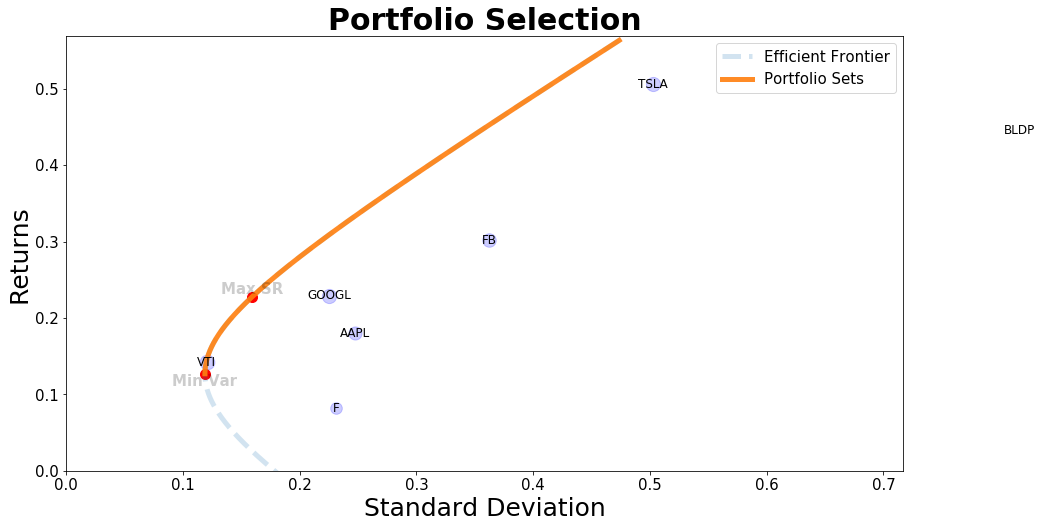

In [28]:
fig,ax = plt.subplots(figsize=(15,8))

port_choice.plot('std','r',
                 linestyle='--',lw = 5,
                 #s=10,
                 alpha = .2,
                 ax = ax)

eff_front.plot('std','r',
               linestyle='-',lw = 5,
               alpha = 0.9,
               ax = ax
              )

for ticker in tickers:
    ann_r = global_returns.mean()[ticker]*ann_factor
    ann_std = global_returns.std()[ticker]*np.sqrt(ann_factor)
    ax.scatter(ann_std,ann_r,
              s = (1+ann_r/ann_std)*100, color = 'b',
              alpha = .2)
    ax.text(ann_std,ann_r,ticker,fontsize=12,va='center',ha='center')

ax.scatter(float(max_sr_port['std']),float(max_sr_port['r']),
          alpha = 1, s = 100,c='red',label='Max SR')
ax.text(float(max_sr_port['std']),float(max_sr_port['r']),
        'Max SR',size=15,fontweight='bold',
         alpha = .2, va='bottom',ha='center')

ax.scatter(float(min_var_port['std']),float(min_var_port['r']),
          alpha = 1, s = 100,c='red',label='Min Var')
ax.text(float(min_var_port['std']),float(min_var_port['r']),
        'Min Var',size=15,fontweight='bold',
         alpha = .2,va='top',ha='center')
    
ax.set_title('Portfolio Selection',fontsize=30,fontweight='bold')
ax.set_xlabel('Standard Deviation',fontsize = 25)
ax.set_ylabel('Returns',fontsize = 25)
ax.tick_params(axis='both',labelsize=15)

ax.set_ylim((0,float(max_sr_port['r'])*2.5))
ax.set_xlim((0,float(max_sr_port['std'])*4.5))

ax.legend(['Efficient Frontier','Portfolio Sets'],fontsize=15)